In [13]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.3.1") # activate the QuantEcon environment
using LinearAlgebra, Statistics, Compat, Plots
gr(fmt=:png) 

Plots.GRBackend()

### Exercise 1

Explore the package [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl)

- Describe 2 abstract types and the hierarchy of 3 different concrete types  
- Benchmark the calculation of some simple linear algebra with a static array compared to the following for a dense arrays for `N=3` and `N=15`  

Part 1

2 abstract types

In [2]:
using Base: show_supertypes
using StaticArrays
show_supertypes(AbstractFloat)
subtypes(AbstractFloat)

AbstractFloat <: Real <: Number <: Any

4-element Array{Any,1}:
 BigFloat
 Float16 
 Float32 
 Float64 

In [3]:
show_supertypes(Unsigned)
subtypes(Unsigned)

Unsigned <: Integer <: Real <: Number <: Any

5-element Array{Any,1}:
 UInt128
 UInt16 
 UInt32 
 UInt64 
 UInt8  

AbstractFloat is a 

3 concrete types

In [4]:
show_supertypes(Bool)

Bool <: Integer <: Real <: Number <: Any

In [5]:
show_supertypes(Float64)

Float64 <: AbstractFloat <: Real <: Number <: Any

In [6]:
show_supertypes(Char)

Char <: AbstractChar <: Any

Part 2

In [7]:
using BenchmarkTools

N = [3 15]
for n in N
    A_c = rand(n, n)
    A_s = @SMatrix rand(n,n)
    x_c = rand(n)
    x_s = @SVector rand(n)
    @btime $A_c * $x_c
    @btime $A_s * $x_s
    @btime inv($A_c)
    @btime inv($A_s)
end

  68.927 ns (1 allocation: 112 bytes)
  2.936 ns (0 allocations: 0 bytes)
  546.428 ns (5 allocations: 1.98 KiB)
  9.570 ns (0 allocations: 0 bytes)
  129.050 ns (1 allocation: 208 bytes)
  67.003 ns (0 allocations: 0 bytes)
  5.133 μs (5 allocations: 9.88 KiB)
  5.422 μs (6 allocations: 11.86 KiB)


### Exercise 2

A key step in the calculation of the Kalman Filter is calculation of the Kalman gain, as can be seen with the following example using dense matrices from [this lecture](kalman)

Using what you learned from Exercise 1, benchmark this using Static Arrays

In [8]:
Σ = [0.4  0.3; 0.3 0.45]
G = I
R = 0.5 * Σ

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R)
@btime gain($Σ, $G, $R)

Σ = @SMatrix([0.4  0.3; 0.3 0.45])
G = @SMatrix([1.0  0.0; 0.0 1.0])
R = 0.5 * Σ

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R)
@btime gain($Σ, $G, $R)

  654.705 ns (10 allocations: 1.94 KiB)
  12.121 ns (0 allocations: 0 bytes)


2×2 SArray{Tuple{2,2},Float64,2,4}:
 0.666667     1.11022e-16
 2.22045e-16  0.666667   

### Exercise 3

The [Polynomial.jl](https://github.com/JuliaMath/Polynomials.jl) provides a package for simple univariate Polynomials.

Plot both `p(x)` and `p′(x)` for $ x \in [-2, 2] $

p = Poly(2 - 5*x + 2*x^2)
(p(0.1), p′(0.1)) = (1.52, -4.6)
roots(p) = [2.0, 0.5]


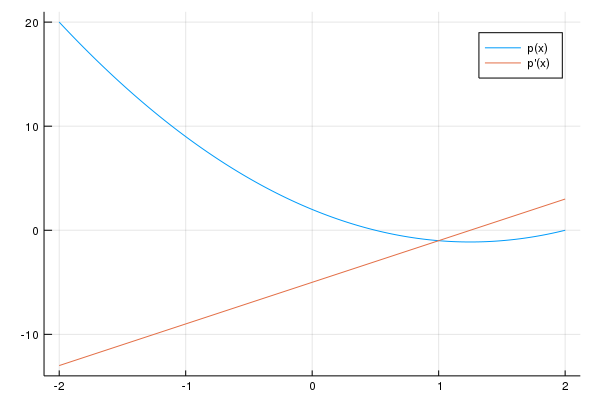

In [17]:
using Polynomials
p = Poly([2, -5, 2], :x) # :x just gives a symbol for display
@show p
p′ = polyder(p)# gives the derivative of p, another polynomial
@show p(0.1), p′(0.1) # call like a function
@show roots(p); # find roots such that p(x) = 0
x = -2:0.01:2
y = hcat(polyval(p,x),polyval(p′,x))
label1 = ["p(x)","p'(x)"]
plot(x,y,label = label1)

### Exercise 4

Using your solution to Exercise 8(a/b) in the [Julia By Example Lecture](julia_by_example) to create a specialized version of Newton’s method for Polynomials, using the `polyder` function

The signature of the function should be `newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter = 100)`, where the `p::Poly` ensure that this version of the function will be used anytime a polynomial is passed (i.e. dispatch)

Compare the results of this function to the built in `roots(p)`

In [10]:
function newtonsmethod(p::Poly, x₀; tolerance = 1E-7,maxiter = 100)
    x_old = x₀
    normdiff = Inf
    iter = 1
    p_prime = polyder(p)
    while normdiff >= tolerance && iter <= maxiter
        x_new = x_old - p(x_old) / p_prime(x_old)
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter += 1
    end
    return x_old
end

p = Poly([2, -5, 2], :x)
x₀ = 0.0
@show newtonsmethod(p,x₀)
@show roots(p)

newtonsmethod(p, x₀) = 0.5
roots(p) = [2.0, 0.5]


2-element Array{Float64,1}:
 2.0
 0.5

Answer:

Newton's Method for polynomials can only find one solution. Meanwhile the `roots` is able find both roots.

### Exercise 5 (Advanced)

The [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)  approximate an integral with

$$
\int_\underline{x}^\bar{x} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

where $ x_0 = \underline{x},\, x_N = \bar{x} $, and $ \Delta x_n \equiv x_{n-1} - x_n $

Given an `x` and a function `f`, implement a few variations of the trapezoidal rule using multiple-dispatch

- `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)`  
- `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`
  * exploit the fact that `AbstractRange` have constant step sizes to specialize the algorithm  
- `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`
  * for this, build a uniform grid with `N` points on `[x̲,x̄]`, call the `f` function at those grid points, and use the existing `trapezoidal(f, x)` from the implementation  


With these,
1. Test each variation of the function with $ f(x) = x^2 $ with $ \underline{x}=0,\, \bar{x} = 1 $
2. From the analytical solution of the function, plot the error of `trapezoidal(f, x̲, x̄, N)` relative to the analytical solution for a grid of different `N` values
3. Consider trying different functions for $ f(x) $ and comparing the solutions for various `N`

When trying different functions, instead of integrating by hand consider using a high-accuracy library for numerical integration such as [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/latest/)

In [30]:
using QuadGK
function trapezoidal(f::AbstractArray, x::AbstractArray)
    @assert length(f) == length(x)
    y = 0.0
    for i in 2:length(x)
        y += (f[i-1]+f[i])/2*(x[i]-x[i-1])
    end
    return y
end

function trapezoidal(f::AbstractRange, x::AbstractRange)
    @assert length(f) == length(x)
    y = 0.0
    for i in 2:length(x)
        y += (f[i-1]+f[i])/2
    end
    return y*step(x)
end

function trapezoidal(f::Function, x_lower::Real, x_upper::Real, N::Real)
    x = range(x_lower, x_upper, length = N)
    y = trapezoidal(f.(x), x)
    return y
end

f(x) = x^2
x_1 = [0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0]
x_2 = range(0.0, 1.0, length = 11)

@show trapezoidal(f.(x_1), x_1)
@show trapezoidal(f.(x_2), x_2)
@show trapezoidal(f, 0.0, 1.0, 11)

trapezoidal(f.(x_1), x_1) = 0.335
trapezoidal(f.(x_2), x_2) = 0.335
trapezoidal(f, 0.0, 1.0, 11) = 0.335


0.335

In [47]:
function compare(f::Function, x_lower::Real, x_upper::Real, N::Real)
    @assert x_lower <= x_upper
    data = zeros(N-1)
    value , accuracy = quadgk(f, 0.0, 1.0)
    for n in 2:N
        data[n-1] = norm(trapezoidal(f, x_lower, x_upper, n) - value)
    end
    label2 = ["error"]
    plot(data, label = label2)
end

compare (generic function with 1 method)

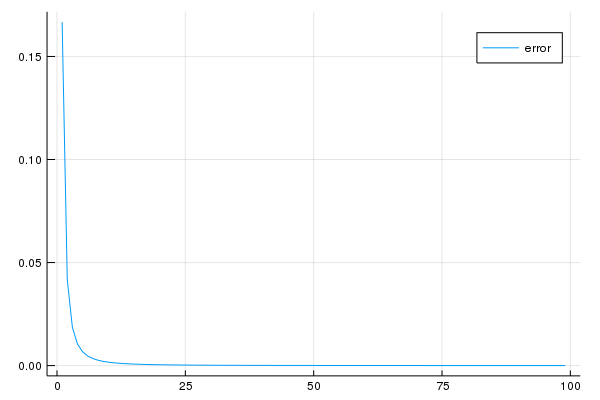

In [48]:
compare(f, 0.0, 1.0, 100)

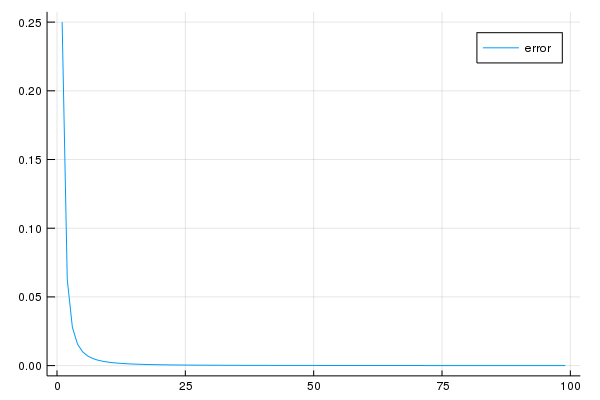

In [53]:
g(x) = x^3
compare(g, 0.0, 1.0, 100)

### Exercise 6 (Advanced)

Take a variation of your code in Exercise 5 which implements the trapezoidal rule for the uniform grid

Use auto-differentiation to calculate the following derivative for the example functions

$$
\frac{d}{d \bar{x}}\int_\underline{x}^\bar{x} f(x) \, dx
$$

Hint: See the following code for the general pattern, and be careful to follow the [rules for generic programming](_generic_tips_tricks)